# INF8808 |  PROJET VIZ 1




In [267]:
import pandas as pd
import numpy as np
import datetime

import plotly.graph_objects as go
import plotly.express as px

In [238]:
def clean_year_column(df):
    # Capture the lenght before dropping
    initial_length = len(df)
    
    # Drop movies for which no date is available
    temp_df = df.dropna(subset=['anneeSortie'])
    
    # Capture the lenght after dropping
    after_drop_length = len(temp_df)
    
    # Cast years to type int
    temp_df = temp_df.astype({'anneeSortie': 'int'})
    
    # Filter movies for which date is greater than now
    temp_df = temp_df[temp_df['anneeSortie']<=datetime.datetime.now().year]
    
    # Capture the length after filtering
    after_filter_length = len(temp_df)
    
    # Compute length deltas
    count_dropped_no_year = initial_length - after_drop_length
    count_filtered_year_greater_now = after_drop_length - after_filter_length
    
    return temp_df, count_dropped_no_year, count_filtered_year_greater_now

In [239]:
def clean_genre_column(df):
    # Capture the lenght before dropping
    initial_length = len(df)

    # Drop movies for which no genre is available
    #temp_df = df.dropna(subset=['genreIdentifiant'])
    
    # Capture the lenght after dropping
    after_drop_length = len(temp_df)
    
    # Cast genres to type str
    #temp_df['genre'] = temp_df['genre'].apply(lambda x: str(x))
    
    # Compute length deltas
    count_dropped_no_genre = initial_length - after_drop_length
    
    return temp_df, count_dropped_no_genre

In [282]:
def clean_title_column(df):
    # Capture the lenght before dropping
    initial_length = len(df)

    # Drop movies for which no title is available
    temp_df = df.dropna(subset=['titreOriginal'])
    temp_df = temp_df.drop_duplicates(subset=['titreOriginal', 'anneeSortie', 'genre', 'sousGenre0', 'sousGenre1'])
    
    # Capture the lenght after dropping
    after_drop_length = len(temp_df)
    
    # Cast titles to type str
    #temp_df = temp_df.astype({'titreOriginal': 'str'})
    
    # Compute length deltas
    count_dropped_no_title = initial_length - after_drop_length
    
    return temp_df, count_dropped_no_title

In [204]:
def replace_str_containing_str(df, column_name, search_str, new_str, contain_word):
    '''
    Si contain_word = True: 
        Cette fonction permet de remplacer les cellules d'un 
        dataframe contenant certains mots par un autre.
        
    Si contain_word = False: 
        Cette fonction permet de remplacer les cellules d'un 
        dataframe NE contenant PAS certains mots par un autre.
    
    Retourne : 
    Le Dataframe modifié
    '''
    
    # Make a local copy 
    temp_df = df.copy()
    
    # Replace string
    if  contain_word == True:
        temp_df.loc[temp_df[column_name].str.contains(search_str, case=False), column_name] = new_str
        
    elif contain_word == False:
        temp_df.loc[~temp_df[column_name].str.contains(search_str, case=False), column_name] = new_str
    
    return temp_df

In [205]:
def clean_film_df_for_sunburst(df):
    
    # Explicit copy
    temp_df = df.copy()
    
    # Clean year, title and genre
    temp_df, count_dropped_no_title = clean_title_column(df=temp_df)
    temp_df, count_dropped_no_year, count_filtered_year_greater_now = clean_year_column(df=temp_df)
    temp_df, count_dropped_no_genre = clean_genre_column(df=temp_df)
    
    print(count_dropped_no_year)
    print(count_dropped_no_title)
    print(count_dropped_no_genre)
    
    # Capitalize genre
    temp_df['genre'] = temp_df['genre'].apply(str.capitalize)
    
    # Replace strings 'VIDÉOS|VIDÉO' for 'Vidéos'
    temp_df = replace_str_containing_str(
        df=temp_df, 
        column_name='genreIdentifiant', 
        search_str='VIDÉOS|VIDÉO', 
        new_str='Vidéos',
        contain_word=True
    )
    
    # Replace strings 'ÉMISSIONS' for 'Émissions'
    temp_df = replace_str_containing_str(
        df=temp_df, 
        column_name='genreIdentifiant', 
        search_str='ÉMISSIONS', 
        new_str='Émissions',
        contain_word=True
    )
    
    # Replace strings 'TV' for 'TV'
    temp_df = replace_str_containing_str(
        df=temp_df, 
        column_name='genreIdentifiant', 
        search_str='TV', 
        new_str='TV',
        contain_word=True
    )
    
    # Replace strings that do not contain 'Vidéos|Émissions|TV' for 'Films'
    temp_df = replace_str_containing_str(
        df=temp_df, 
        column_name='genreIdentifiant', 
        search_str='Vidéos|Émissions|TV', 
        new_str='Films',
        contain_word=False
    )

    return temp_df

In [228]:
def clean_film_df_for_sunburst(df):
    
    temp_df = df.replace(r'^\s*$', '.', regex=True)
        
    # Clean year, title and genre
    temp_df, count_dropped_no_title = clean_title_column(df=temp_df)
    temp_df, count_dropped_no_year, count_filtered_year_greater_now = clean_year_column(df=temp_df)
    temp_df, count_dropped_no_genre = clean_genre_column(df=temp_df)
    
    # Capitalize genre
    temp_df['genre'] = temp_df['genre'].apply(str.upper)
    
    return temp_df

In [215]:
def create_sunburst_df(df):
    '''
    Cette fonction permet le pretraitement des données pour
    correspondre la structure du Sunburst de Plotly.
    Autrement dit, il faut construire: 
        - Une liste des labels de TOUS les niveaux de genre
        - Une liste avec le 'parent' de chacun des labels
        - Une liste avec les valeurs de chacun des labels
    
    Retourne:
        - Un dataframe avec l'ensemble des films avec les différents
        'niveaux de genres' auxquels ils appartiennent.
        - Un dataframe avec les données pour le sunburst.
    '''
    # Create explicit copy
    temp_df = df.copy()
    
    # Create levels 
    genre = (temp_df
        .groupby(['genre'])
        .size()
    )
    subgenre0 = (temp_df
        .groupby(['sousGenre0'])
        .size()
        .drop(".", errors='ignore')
    )
    subgenre1 = (temp_df
        .groupby(['sousGenre1'])
        .size()
        .drop(".", errors='ignore')
    )
    
    # Create "values"
    genre_values = genre.to_list()
    subgenre0_values = subgenre0.to_list()
    subgenre1_values = subgenre1.to_list()
    values = [*genre_values, *subgenre0_values, *subgenre1_values] 
    
    # Create "labels"
    genre_labels = genre.index.values.tolist()
    subgenre0_labels = subgenre0.index.values.tolist()
    subgenre1_labels = subgenre1.index.values.tolist()
    labels = [*genre_labels, *subgenre0_labels, *subgenre1_labels] 
    
    # Create "parents" - extract tuples
    subgenre0_tuples = (temp_df
        .groupby(['sousGenre0', 'genre'])
        .size()
        .drop(".", errors='ignore')
        .index
        .values
    )
    subgenre1_tuples = (temp_df
        .groupby(['sousGenre1', 'sousGenre0'])
        .size()
        .drop(".", errors='ignore')
        .index
        .values
    )
    
    # Create "parents"
    genre_parents = [""] * len(genre_values) # No parents for level 1
    subgenre0_parents = [i[1] for i in subgenre0_tuples]
    subgenre1_parents = [i[1] for i in subgenre1_tuples]
    parents = [*genre_parents, *subgenre0_parents, *subgenre1_parents] 
    
    # Create sunburst_df 
    sunburst_df = pd.DataFrame({
        'labels': labels,
        'parents': parents, 
        'values': values
    })
    
    return sunburst_df

In [287]:
def create_sunburst_fig(df): #, list_hovertemplate):
    # Initialisation
    fig = go.Figure()

    # On trace le sunburst souhaité
    fig.add_trace(
        go.Sunburst(
            labels=df['labels'],
            parents=df['parents'],
            values=df['values'],
            branchvalues='total',
            insidetextorientation='radial',
            maxdepth=3,
            rotation=90,
            sort=True,
            marker_colorscale='twilight', # A CHANGER PAR RAPPORT AU THEME
        )
    )

    # On met à jour les paramètres de présenation de la figure
    fig.update_layout(
        width=800,
        height=800,
        title='Hiérarchie des différents genres cinématographiques',
        uniformtext_minsize=10,
        uniformtext_mode='hide',
    )

    return fig

In [224]:
film_df.columns.values.tolist()

['FilmoId',
 'titreOriginal',
 'anneeSortie',
 'GeneriqueId',
 'fonction',
 'nom',
 'prenom',
 'nomComplet',
 'langue',
 'pays',
 'continent',
 'capitale',
 'planete',
 'genreIdentifiant',
 'genre',
 'sousGenre0',
 'sousGenre1']

In [283]:
film_df = pd.read_csv(
    filepath_or_buffer='../Src/Assets/Data/Jc/film_vsMaitre.csv',
    sep=',',
    header=0,
    low_memory=False,
    dtype={
        'FilmoId': int,
        'titreOriginal': str,
        'anneeSortie': int,
        'GeneriqueId': float,
        'fonction': str,
        'nom': str,
        'prenom': str,
        'nomComplet': str,
        'langue': str,
        'pays': str,
        'continent': str,
        'capitale': str,
        'planete': str,
        'genreIdentifiant': str,
        'genre': str,
        'sousGenre0': str,
        'sousGenre1': str
    }
)

In [ ]:
temp_df = film_df.replace(r'^\s*$', None, regex=True)
        
# Clean year, title and genre
temp_df, count_dropped_no_title = clean_title_column(df=temp_df)
temp_df, count_dropped_no_year, count_filtered_year_greater_now = clean_year_column(df=temp_df)
temp_df, count_dropped_no_genre = clean_genre_column(df=temp_df)

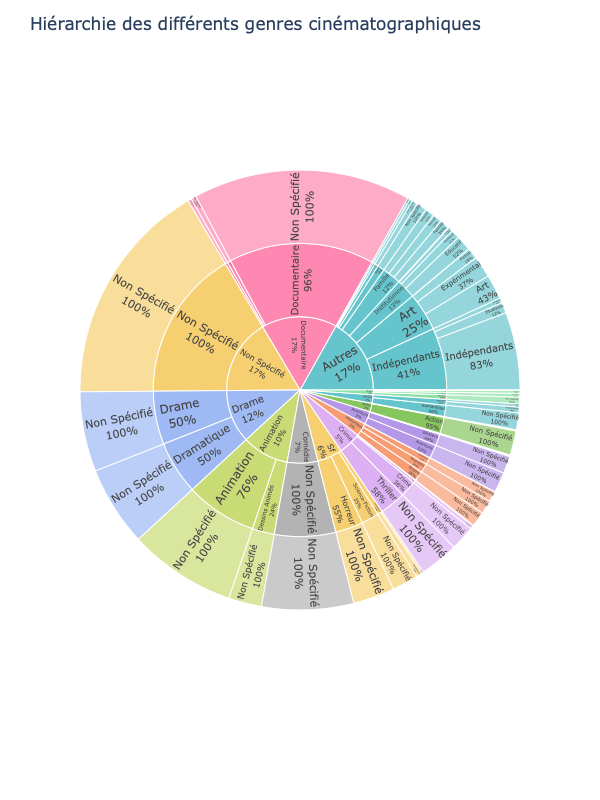

In [341]:
temp_df["genre"] = temp_df["genre"].fillna("Non Spécifié")
temp_df["sousGenre0"] = temp_df["sousGenre0"].fillna("Non Spécifié")
temp_df["sousGenre1"] = temp_df["sousGenre1"].fillna("Non Spécifié")

fig = px.sunburst(
    data_frame=temp_df,
    path=["genre", "sousGenre0", "sousGenre1"], # root, branches, leaves
    maxdepth=-1,
    branchvalues='total',
    color="genre",
    color_discrete_sequence=px.colors.qualitative.Pastel,
)

#fig.update_traces(textinfo='label+percent entry')
fig.update_traces(
    #insidetextfont_
    insidetextorientation='radial',
    textinfo='label+percent parent',
)

fig.update_layout(
    width=800,
    height=800,
    title='Hiérarchie des différents genres cinématographiques',
    uniformtext_minsize=10,
    )
    
fig.show()

In [343]:
fig.full_figure_for_development(warn=False).show('json')

In [319]:
temp_df = film_df.replace(r'^\s*$', None, regex=True)
        
# Clean year, title and genre
temp_df, count_dropped_no_title = clean_title_column(df=temp_df)
temp_df, count_dropped_no_year, count_filtered_year_greater_now = clean_year_column(df=temp_df)
temp_df, count_dropped_no_genre = clean_genre_column(df=temp_df)


# Create levels 
genre = (temp_df
    .groupby(['genre'])
    .size()
    #.drop(None, errors='ignore')
)
subgenre0 = (temp_df
    .groupby(['sousGenre0'])
    .size()
    #.drop(None, errors='ignore')
)
subgenre1 = (temp_df
    .groupby(['sousGenre1'])
    .size()
    #.drop(None, errors='ignore')
)

# Create "values"
genre_values = genre.to_list()
subgenre0_values = subgenre0.to_list()
subgenre1_values = subgenre1.to_list()
#values = [*genre_values, *subgenre0_values, *subgenre1_values] 
values = [*genre_values, *subgenre0_values] 
#values = [*genre_values] 

# Create "labels"
genre_labels = genre.index.values.tolist()
subgenre0_labels = subgenre0.index.values.tolist()
subgenre1_labels = subgenre1.index.values.tolist()
#labels = [*genre_labels, *subgenre0_labels, *subgenre1_labels] 
labels = [*genre_labels, *subgenre0_labels] 
#labels = [*genre_labels] 

# Create "parents"
genre_parents = [''] * len(genre_values) # No parents for level 1
subgenre0_tuples = (temp_df
    .groupby(['sousGenre0', 'genre'])
    .size()
    #.drop(".", errors='ignore')
    .index
    .values
)
subgenre0_parents = [i[1] for i in subgenre0_tuples]  
subgenre1_tuples = (temp_df
    .groupby(['sousGenre1', 'sousGenre0'])
    .size()
    #.drop(".", errors='ignore')
    .index
    .values
) 
subgenre1_parents = [i[1] for i in subgenre1_tuples]
#parents = [*genre_parents, *subgenre0_parents, *subgenre1_parents] 
parents = [*genre_parents, *subgenre0_parents]
#parents = [*genre_parents]

# Create sunburst_df 
sunburst_df = pd.DataFrame({
    'labels': labels,
    'parents': parents, 
    'values': values
})

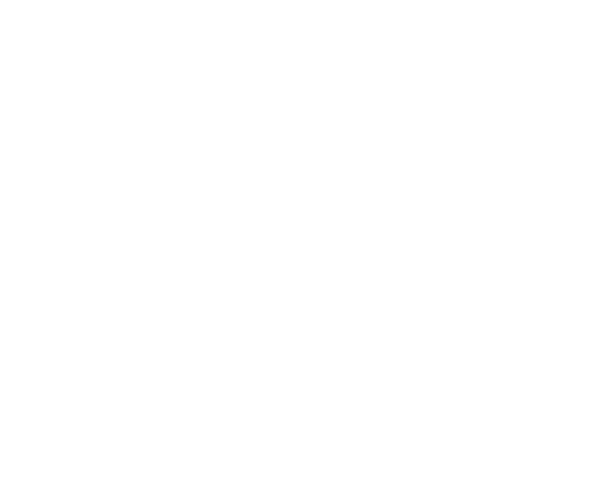

In [266]:
fig.full_figure_for_development(warn=False)